<a href="https://colab.research.google.com/github/ConanOReilly/Final_Year_Project/blob/main/Multi_Modal_Predictions/JIFMMFAPAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Joint-individual fusion structure with fusion attention module for multi-modal skin cancer classification**
Source code was not available for this model, however the architecture from the paper was replicated to attempt to achieve similar results.

Tang, Peng, et al. "Joint-individual fusion structure with fusion attention module for multi-modal skin cancer classification." Pattern Recognition 154 (2024): 110604.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import timm
from tqdm import tqdm

In [ ]:
# Dataset
class PADUFESDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.meta_cols = [col for col in df.columns if col not in ['img_id', 'image_path', 'diagnostic', 'patient_id']]

        self.label_encoder = LabelEncoder()
        self.df['label'] = self.label_encoder.fit_transform(self.df['diagnostic'])
        self.num_classes = len(self.df['label'].unique())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_path'])
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            image = self.transform(image=image)["image"]

        metadata = torch.tensor(row[self.meta_cols].values.astype(np.float32))
        label = torch.tensor(row['label']).long()
        return image, metadata, label

# **Model**

In [ ]:
class MMFA(nn.Module):
    def __init__(self, dim, heads):
        super(MMFA, self).__init__()
        self.qkv_image = nn.Linear(dim, dim * 3)
        self.qkv_meta = nn.Linear(dim, dim * 3)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.out_proj = nn.Linear(dim, dim)

    def forward(self, image_feat, meta_feat):
        qkv_i = self.qkv_image(image_feat)
        qkv_m = self.qkv_meta(meta_feat)
        q_i, k_i, v_i = torch.chunk(qkv_i, 3, dim=-1)
        q_m, k_m, v_m = torch.chunk(qkv_m, 3, dim=-1)

        q = torch.cat([q_i, q_m], dim=1)
        k = torch.cat([k_i, k_m], dim=1)
        v = torch.cat([v_i, v_m], dim=1)

        attn_output, _ = self.attn(q, k, v)
        fused = self.out_proj(attn_output.mean(dim=1))
        return torch.cat([fused, image_feat.squeeze(1), meta_feat.squeeze(1)], dim=-1)


class JIF_MMFA_Model(nn.Module):
    def __init__(self, image_model, meta_dim, num_classes, dim_hidden=128, num_heads=4):
        super(JIF_MMFA_Model, self).__init__()
        self.image_model = image_model
        self.meta_net = nn.Sequential(
            nn.Linear(meta_dim, dim_hidden),
            nn.ReLU()
        )
        self.mmfa = MMFA(dim=dim_hidden, heads=num_heads)

        self.image_cls = nn.Linear(dim_hidden, num_classes)
        self.meta_cls = nn.Linear(dim_hidden, num_classes)
        self.fusion_cls = nn.Linear(384, num_classes)

    def forward(self, image, meta):
        image_feat = self.image_model(image)
        meta_feat = self.meta_net(meta)

        img_seq = image_feat.unsqueeze(1)
        meta_seq = meta_feat.unsqueeze(1)

        fusion_feat = self.mmfa(img_seq, meta_seq)

        pred_image = self.image_cls(image_feat)
        pred_meta = self.meta_cls(meta_feat)
        pred_fused = self.fusion_cls(fusion_feat)

        return pred_image, pred_meta, pred_fused

**Training, Evaluation, Metrics**

In [ ]:
def train_loop(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0

    for images, metadata, labels in tqdm(loader, desc="Training"):
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

        pred_image, pred_meta, pred_fused = model(images, metadata)

        loss_image = criterion(pred_image, labels)
        loss_meta = criterion(pred_meta, labels)
        loss_fused = criterion(pred_fused, labels)
        loss = 0.5 * loss_image + 0.5 * loss_meta + loss_fused

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        correct += (pred_fused.argmax(1) == labels).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, metadata, labels in tqdm(loader, desc="Evaluating"):
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            _, _, pred_fused = model(images, metadata)
            loss = criterion(pred_fused, labels)
            total_loss += loss.item() * images.size(0)
            correct += (pred_fused.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, metadata, labels in loader:
            images, metadata = images.to(device), metadata.to(device)
            _, _, preds = model(images, metadata)
            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_labels), np.array(all_preds)

**Running Model**

In [ ]:
def run_training():
    IMG_DIR = "/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/imgs"
    CSV_TRAIN = "/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/pad-ufes-20_parsed_folders.csv"
    CSV_TEST = "/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/pad-ufes-20_parsed_test.csv"

    df_train = pd.read_csv(CSV_TRAIN)
    df_test = pd.read_csv(CSV_TEST)

    df_train['image_path'] = df_train['img_id']
    df_test['image_path'] = df_test['img_id']
    aug = A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.Rotate(limit=30),
        A.Normalize(),
        ToTensorV2()
    ])

    train_dataset = PADUFESDataset(df_train, IMG_DIR, transform=aug)
    test_dataset = PADUFESDataset(df_test, IMG_DIR, transform=aug)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    num_classes = train_dataset.num_classes
    meta_dim = len(train_dataset.meta_cols)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    base_model = timm.create_model('tf_efficientnetv2_b0', pretrained=True, num_classes=128)
    image_model = base_model

    model = JIF_MMFA_Model(image_model=image_model, meta_dim=meta_dim, num_classes=num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, 21):
        train_loss, train_acc = train_loop(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Save model
    SAVE_PATH = "/content/drive/MyDrive/Final Year Project/Code/JIFMMFA/jif_mmfa_model.pt"
    torch.save(model.state_dict(), SAVE_PATH)
    print(f"Model saved to {SAVE_PATH}")

    return model, train_loader, test_loader, train_losses, val_losses, train_accuracies, val_accuracies, device, train_dataset

In [ ]:
model, train_loader, test_loader, train_losses, val_losses, train_accuracies, val_accuracies, device, train_dataset = run_training()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/28.8M [00:00<?, ?B/s]

Evaluating: 100%|██████████| 24/24 [02:29<00:00,  6.21s/it]


Epoch 01 | Train Loss: 12.4856 | Val Loss: 1.8564 | Train Acc: 0.3640 | Val Acc: 0.4178


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


Epoch 02 | Train Loss: 3.6136 | Val Loss: 1.2473 | Train Acc: 0.5347 | Val Acc: 0.5875


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.48it/s]


Epoch 03 | Train Loss: 2.4352 | Val Loss: 1.2042 | Train Acc: 0.6057 | Val Acc: 0.5561


Evaluating: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


Epoch 04 | Train Loss: 2.1845 | Val Loss: 1.0649 | Train Acc: 0.6527 | Val Acc: 0.6684


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


Epoch 05 | Train Loss: 2.0384 | Val Loss: 1.0134 | Train Acc: 0.6768 | Val Acc: 0.6632


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.46it/s]


Epoch 06 | Train Loss: 1.8467 | Val Loss: 0.9100 | Train Acc: 0.7144 | Val Acc: 0.6632


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.45it/s]


Epoch 07 | Train Loss: 1.7416 | Val Loss: 0.7217 | Train Acc: 0.7332 | Val Acc: 0.7624


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.47it/s]


Epoch 08 | Train Loss: 1.6307 | Val Loss: 0.7687 | Train Acc: 0.7462 | Val Acc: 0.7415


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.49it/s]


Epoch 09 | Train Loss: 1.5309 | Val Loss: 0.7691 | Train Acc: 0.7723 | Val Acc: 0.7180


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


Epoch 10 | Train Loss: 1.4018 | Val Loss: 0.7750 | Train Acc: 0.7864 | Val Acc: 0.7467


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.49it/s]


Epoch 11 | Train Loss: 1.3108 | Val Loss: 0.6297 | Train Acc: 0.8198 | Val Acc: 0.7781


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.48it/s]


Epoch 12 | Train Loss: 1.2112 | Val Loss: 0.5831 | Train Acc: 0.8319 | Val Acc: 0.7911


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


Epoch 13 | Train Loss: 1.1162 | Val Loss: 0.7350 | Train Acc: 0.8559 | Val Acc: 0.7598


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.48it/s]


Epoch 14 | Train Loss: 1.0435 | Val Loss: 0.6875 | Train Acc: 0.8752 | Val Acc: 0.7546


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


Epoch 15 | Train Loss: 0.9672 | Val Loss: 0.7520 | Train Acc: 0.8888 | Val Acc: 0.7520


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.48it/s]


Epoch 16 | Train Loss: 0.8976 | Val Loss: 0.7782 | Train Acc: 0.9044 | Val Acc: 0.7180


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.48it/s]


Epoch 17 | Train Loss: 0.8732 | Val Loss: 0.8858 | Train Acc: 0.9076 | Val Acc: 0.7337


Evaluating: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


Epoch 18 | Train Loss: 0.8060 | Val Loss: 0.9227 | Train Acc: 0.9264 | Val Acc: 0.7258


Evaluating: 100%|██████████| 24/24 [00:16<00:00,  1.45it/s]


Epoch 19 | Train Loss: 0.7583 | Val Loss: 0.8347 | Train Acc: 0.9279 | Val Acc: 0.7546


Evaluating: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


Epoch 20 | Train Loss: 0.7439 | Val Loss: 0.8324 | Train Acc: 0.9238 | Val Acc: 0.7363
Model saved to /content/drive/MyDrive/Final Year Project/Code/JIFMMFA/jif_mmfa_model.pt


# **Evaluation**

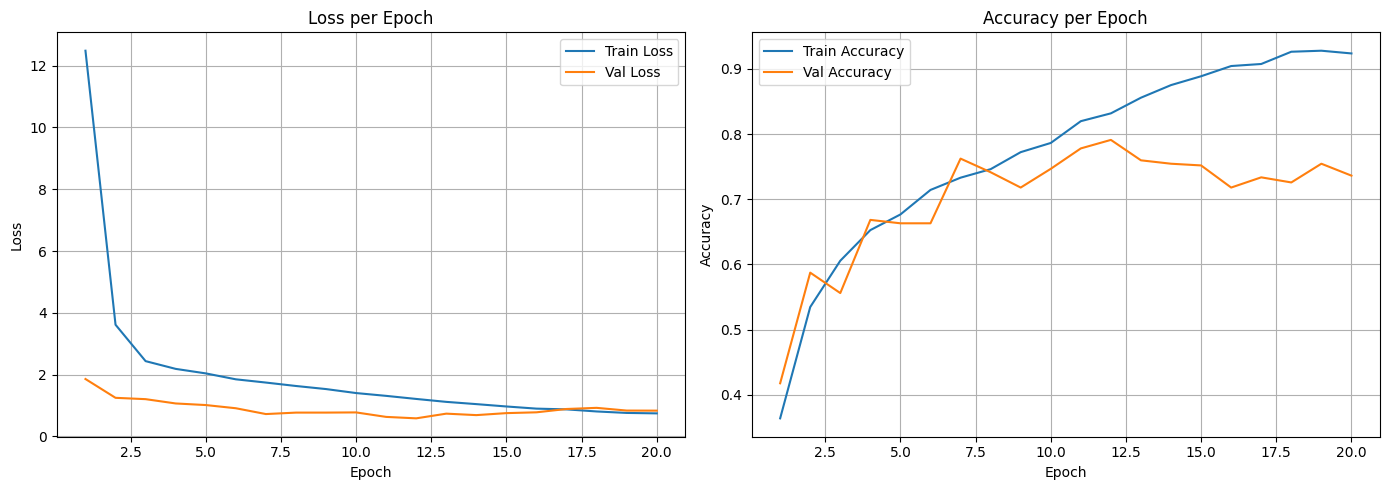

Classification Report:

              precision    recall  f1-score   support

         ACK       0.87      0.81      0.84       122
         BCC       0.84      0.74      0.79       141
         MEL       0.80      0.44      0.57         9
         NEV       0.69      0.88      0.77        40
         SCC       0.38      0.59      0.46        32
         SEK       0.87      0.85      0.86        39

    accuracy                           0.77       383
   macro avg       0.74      0.72      0.71       383
weighted avg       0.80      0.77      0.78       383



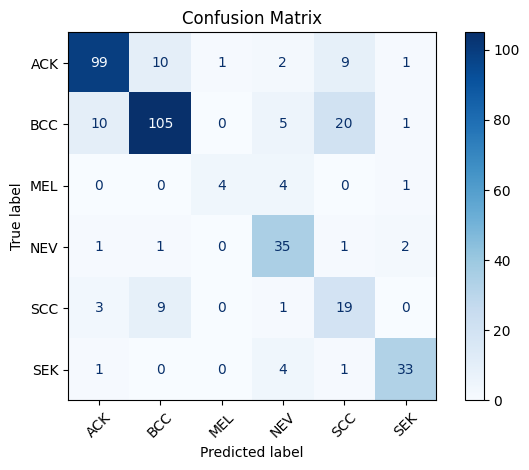

In [ ]:
# Plot Loss and Accuracy
epochs = list(range(1, len(train_losses) + 1))
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Classification report and confusion matrix
y_true, y_pred = get_predictions(model, test_loader, device)
class_names = train_dataset.label_encoder.classes_

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()